In [82]:
import numpy as np
from scipy.spatial import KDTree
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd


def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    # Extract coordinates
    coordinates = np.array([(core['x'], core['y']) for core in cores])

    # Normalize coordinates (shift to origin) and invert y-axis
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array(
        [(x - min_x, max_y - y) for x, y in coordinates]
    )

    return normalized_inverted_coordinates


def estimate_grid(normalized_coordinates):
    """
    Estimate the grid pattern based on normalized core coordinates.
    :param normalized_coordinates: Array of normalized core coordinates.
    :return: Estimated row and column deltas.
    """
    # Compute pairwise distances
    kdtree = KDTree(normalized_coordinates)
    # Query the nearest two points for each point
    distances, _ = kdtree.query(normalized_coordinates, k=2)

    # Estimate grid spacing
    # Average distance to the nearest neighbor
    avg_distance = np.median(distances[:, 1])
    return avg_distance


def assign_to_grid(normalized_coordinates, grid_spacing, threshold_distance):
    """
    Assign each core to a grid position based on estimated grid spacing, considering
    the inverted y-axis. Also, adjust assignments for neighbor consistency.
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :param threshold_distance: Distance threshold for considering neighbors.
    :return: Dictionary of core positions with row and column assignments.
    """
    # Initialize dictionary of core positions with row and column assignments.
    grid_positions = defaultdict(list)

    # First pass: initial assignment
    for idx, coord in enumerate(normalized_coordinates):
        # Get row and column for each core coordinate
        row, col = get_row_col(coord, grid_spacing)
        # Append index of core coordinate to corresponding row and column.
        grid_positions[(row, col)].append(idx)

    # Extract x and y coordinates separately for KDTree construction
    x_coords = normalized_coordinates[:, 0]
    y_coords = normalized_coordinates[:, 1]

    # Second pass: adjust for neighbor consistency
    for (row, col), core_indices in list(grid_positions.items()):
        for core_index in core_indices:
            core_coord = normalized_coordinates[core_index]

            # Get column neighbors based on x-coordinate
            col_neighbors_indices = get_column_neighbors(
                core_coord[0], x_coords, threshold_distance)
            col_neighbor_x_values = x_coords[col_neighbors_indices]

            # Get row neighbors based on y-coordinate
            row_neighbors_indices = get_row_neighbors(
                core_coord[1], y_coords, threshold_distance)
            row_neighbor_y_values = y_coords[row_neighbors_indices]

            # Determine correct row and column
            correct_col = determine_correct_column(
                col_neighbor_x_values, grid_spacing)
            correct_row = determine_correct_row(
                row_neighbor_y_values, grid_spacing)

            # Reassign core if necessary
            if correct_row != row or correct_col != col:
                grid_positions[(correct_row, correct_col)].append(core_index)
                grid_positions[(row, col)].remove(core_index)

    return grid_positions


def get_column_neighbors(x_value, x_coords, threshold_distance):
    """
    Find neighboring cores within a specified distance based on x-coordinate.
    """
    kdtree = KDTree(x_coords.reshape(-1, 1))  # KDTree with only x-coordinates
    indices = kdtree.query_ball_point(x_value, threshold_distance)
    return indices


def get_row_neighbors(y_value, y_coords, threshold_distance):
    """
    Find neighboring cores within a specified distance based on y-coordinate.
    """
    kdtree = KDTree(y_coords.reshape(-1, 1))  # KDTree with only y-coordinates
    indices = kdtree.query_ball_point(y_value, threshold_distance)
    return indices


def get_row_col(coord, grid_spacing):
    """
    Extract the row and column from a coordinate.
    :param coord: The coordinate (x, y).
    :param grid_spacing: The grid spacing.
    :return: Tuple of (row, column).
    """
    row = int(round(coord[1] / grid_spacing))
    col = int(round(coord[0] / grid_spacing))
    return row, col


def determine_correct_row_col(neighbor_coords, grid_spacing):
    """
    Determine the most common row and column among neighbors.
    :param neighbor_coords: List of neighbor coordinates.
    :param grid_spacing: The grid spacing.
    :return: Tuple of the most common (row, column).
    """
    row_col_counts = defaultdict(int)
    for coord in neighbor_coords:
        row_col = get_row_col(coord, grid_spacing)
        row_col_counts[row_col] += 1
    return max(row_col_counts, key=row_col_counts.get)


def determine_correct_column(x_values, grid_spacing):
    """
    Determine the most common column among neighbors based on x-values.
    """
    col_counts = defaultdict(int)
    for x in x_values:
        col = int(round(x / grid_spacing))
        col_counts[col] += 1
    return max(col_counts, key=col_counts.get)


def determine_correct_row(y_values, grid_spacing):
    """
    Determine the most common row among neighbors based on y-values.
    """
    row_counts = defaultdict(int)
    for y in y_values:
        row = int(round(y / grid_spacing))
        row_counts[row] += 1
    return max(row_counts, key=row_counts.get)

In [83]:
# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_104_1_009_1.json')
data = data.to_dict('records')

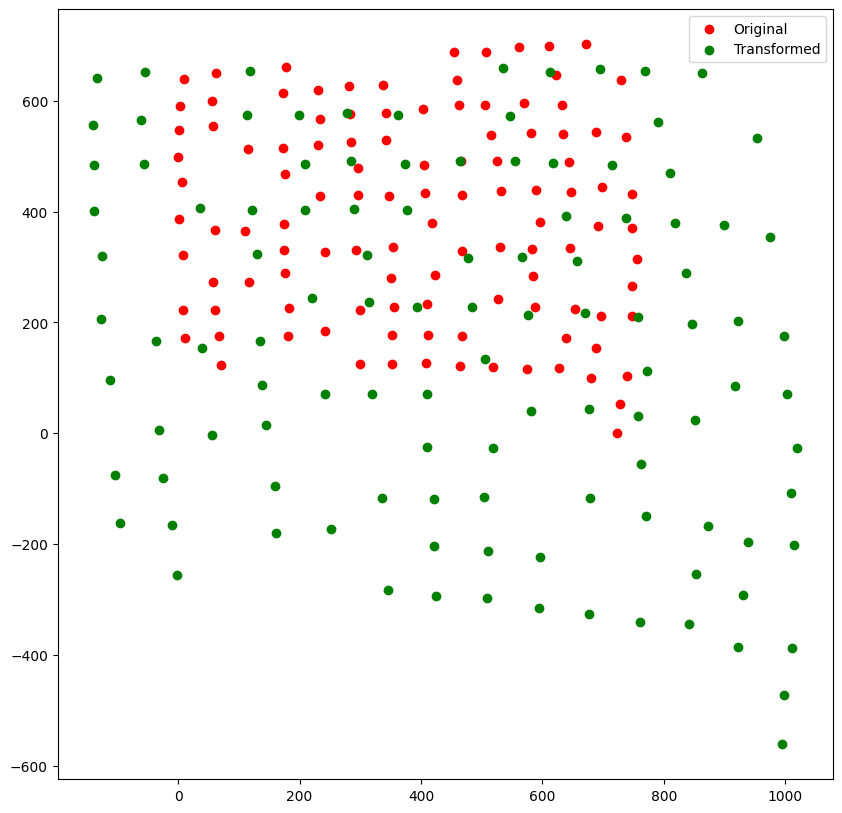

In [84]:
import numpy as np
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from skimage.transform import estimate_transform

def find_control_points(cores):
    # Assuming 'cores' is a list of (x, y) tuples
    # Convert cores to a numpy array for easier manipulation
    core_array = np.array(cores)

    # Top-left core will have the smallest sum of coordinates
    top_left = core_array[np.argmin(np.sum(core_array, axis=1))]
    
    # Top-right core will have the largest x minus y value
    top_right = core_array[np.argmax(core_array[:, 0] - core_array[:, 1])]
    
    # Bottom-left core will have the largest y minus x value
    bottom_left = core_array[np.argmax(core_array[:, 1] - core_array[:, 0])]
    
    # Bottom-right core will have the largest sum of coordinates
    bottom_right = core_array[np.argmax(np.sum(core_array, axis=1))]

    return top_left, top_right, bottom_left, bottom_right

# Apply the transformation to all core coordinates
normalized_coordinates = preprocess_cores(data)

# Now, let's find the control points
control_points = find_control_points([(core['x'], core['y']) for core in data])

# Define the corresponding target points for a 1024 x 1024 image
target_points = np.array([[0, 0], [1024, 0], [0, 1024], [1024, 1024]])

def get_affine_transform(src_coords, dst_coords):
    """
    Estimate the affine transformation matrix from source to destination coordinates.
    :param src_coords: (4, 2)-shaped array of source coordinates.
    :param dst_coords: (4, 2)-shaped array of destination coordinates.
    :return: skimage's AffineTransform object.
    """
    assert src_coords.shape == dst_coords.shape == (4, 2), "There must be four control points."
    
    transform = estimate_transform('affine', src_coords, dst_coords)
    return transform

# Assuming the control points and target points have been correctly identified
affine_transform = get_affine_transform(np.array(control_points), np.array(target_points))

# Apply the transformation to the entire set of coordinates
transformed_coordinates = affine_transform(normalized_coordinates)


# Plotting for verification
plt.figure(figsize=(10, 10))
plt.scatter(*zip(*normalized_coordinates), c='r', label='Original')
plt.scatter(*zip(*transformed_coordinates), c='g', label='Transformed')
plt.legend()
plt.show()


In [68]:
transformed_coordinates

array([[ -152.36571164,  -672.9058297 ],
       [ -143.41570349,  -884.3929395 ],
       [ -137.42494272, -1113.94127352],
       [  -46.19261973, -1120.35178345],
       [  -47.63103145,  -892.22149512],
       [   17.7369388 ,  -297.47460541],
       [   53.33592872,  -865.82382678],
       [   63.49004287, -1114.30782775],
       [  111.47612043,  -292.3525508 ],
       [  126.64077585,  -626.76128573],
       [  146.69001521,  -883.38392266],
       [  214.37595004,  -278.51368505],
       [  239.5806929 ,  -608.63441416],
       [  252.0525634 ,  -886.6582531 ],
       [  303.60861169,  -260.35970693],
       [  323.35547327,  -597.09013655],
       [  335.4544105 ,  -868.14107096],
       [  399.87938991,  -187.18586484],
       [  426.63720794,  -600.21807693],
       [  438.29068939,  -821.65639081],
       [  488.60738431,  -162.5867525 ],
       [  519.00082581,  -582.10935143],
       [  525.0584046 ,  -817.73642258],
       [  595.6443558 ,  -172.71241898],
       [  616.14

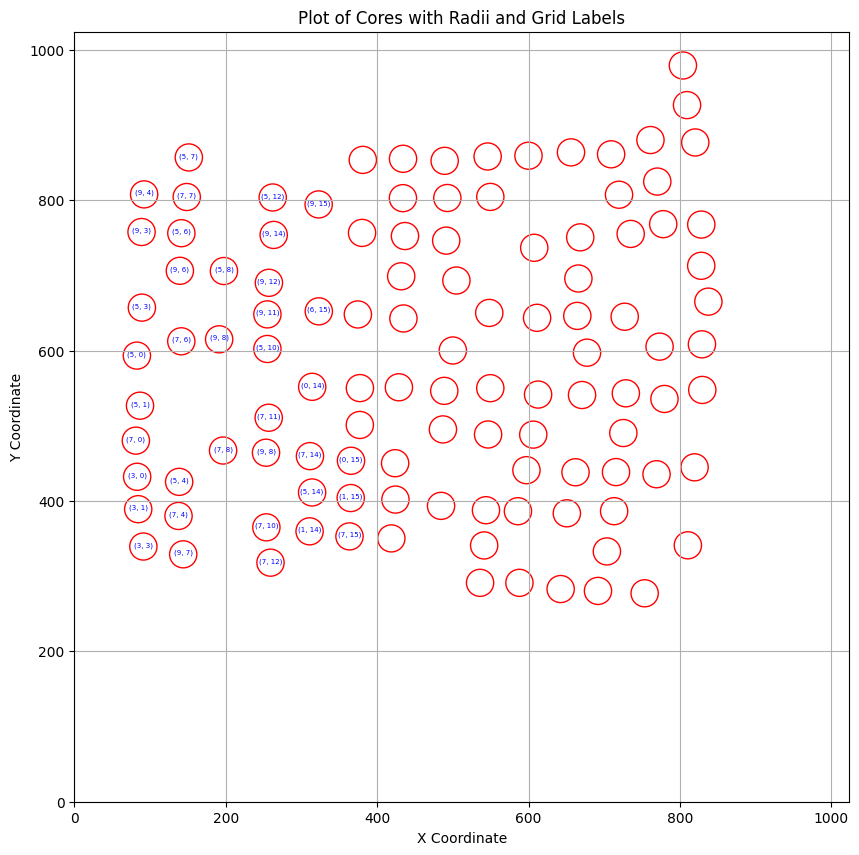

In [86]:

# grid_spacing = estimate_grid(transformed_coordinates)
grid_spacing = estimate_grid(normalized_coordinates)


# Define a threshold distance, for example, 0.5 times the grid spacing
threshold_distance = 1 * grid_spacing

grid_positions = assign_to_grid(normalized_coordinates, grid_spacing, threshold_distance)


# Now we will attempt the plotting again, making sure to access the dictionary correctly
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot each core with its radius and label
for idx, core in enumerate(data):
    # Draw the core as a circle
    circle = plt.Circle((core['x'], core['y']), radius=core['radius'], edgecolor='r', facecolor='none')
    ax.add_patch(circle)

    # Get grid position for the label
    grid_label = None
    for pos, indices in grid_positions.items():
        if idx in indices:
            grid_label = pos
            break
    
    # Only label the core if we found a grid position
    if grid_label is not None:
        ax.text(core['x'], core['y'], str(grid_label), color='blue', fontsize=5, ha='center')

# Set the limits of the plot to the size of the image
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])

# Add grid, legend, and labels
ax.grid(True)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Plot of Cores with Radii and Grid Labels')

# Show the plot
plt.show()